In [107]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
plt.style.use('ggplot')
import seaborn as sns
pd.options.display.float_format = '{:,.0f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import dataframe_image as dfi
from pandas.api.types import CategoricalDtype
from matplotlib.ticker import MultipleLocator, FuncFormatter
from scipy.stats import loguniform, uniform, randint
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [53]:
#Import Accepted_Rejected
Accepted_Rejected_Ord = pd.read_csv('Accepted_Rejected_OrdEncoded.csv')

In [54]:
Accepted_Rejected_Ord.head()

,Loan_Amount,Risk_Score,Debt-Income,State,Employment_Length,Year,Credit_Policy,Application
0,"3,600",677,6,PA,10,2015,1,0
1,"24,700",717,16,SD,10,2015,1,0
2,"20,000",697,11,IL,10,2015,1,0
3,"35,000",787,17,NJ,10,2015,1,0
4,"10,400",697,25,PA,3,2015,1,0


In [55]:
X_Num_Ord = Accepted_Rejected_Ord.drop(['Application', 'Year', 'State'], axis=1)
#X_Nominal = Accepted_Rejected_Ord[['State']]
Y = Accepted_Rejected_Ord['Application']

In [56]:
#One Hot Encode Nominal (State).  #Initially tried to incorporate state but am now dropping State completely for efficiency
'''
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_Nominal_One_Hot = encoder.fit_transform(X_Nominal)
X_Nominal_One_Hot_df = pd.DataFrame(
    X_Nominal_One_Hot,
    columns=encoder.get_feature_names_out(X_Nominal.columns),
    index=Accepted_Rejected_Ord.index
)
#Merge
X = pd.merge(
    X_Num_Ord,
    X_Nominal_One_Hot_df,
    left_index=True,
    right_index=True,
    how='left'
)
'''
X = X_Num_Ord

In [7]:
X.shape

(11004999, 5)

In [57]:
#Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y, random_state=2)
X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=.2, stratify=Y_train, random_state=2)

#Scale numeric features
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#Scale training subsample
scaler_sub = StandardScaler()
X_sub, _, Y_sub, _ = train_test_split(X_train, Y_train, train_size=1000000, stratify=Y_train, random_state=2)
X_sub_scaled = scaler_sub.fit_transform(X_sub)

In [67]:
#Logistic Regression (Base)
logreg = LogisticRegression(
    max_iter=100,
    class_weight='balanced',
    solver='saga',
    penalty='l2',
    n_jobs=-1,
    tol=1e-3
)

logreg.fit(X_tr_scaled, Y_tr)

logreg_val_auc = roc_auc_score(Y_val, logreg.predict_proba(X_val_scaled)[:, 1])
logreg_test_auc = roc_auc_score(Y_test, logreg.predict_proba(X_test_scaled)[:, 1])

print('Logistic Regression Validation ROC-AUC:', logreg_val_auc)
print('Logistic Regression Test ROC-AUC:', logreg_test_auc)

Logistic Regression Validation ROC-AUC: 0.9407905149131417
Logistic Regression Test ROC-AUC: 0.9407316737695819


In [68]:
#Logistic Regression (Randomized Serach CV)
logreg_param_dist = {'C': loguniform(1e-4, 1e2)}

logreg_randCV = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=logreg_param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=2),
    random_state=5,
    n_jobs=-1,
    error_score= np.nan
)

#Fit on scaled subsample
logreg_randCV.fit(X_sub_scaled, Y_sub)
print('Logistic Regression Best Parameters:', logreg_randCV.best_params_)

Logistic Regression Best Parameters: {'C': np.float64(0.00030510379709992175)}


In [69]:
#Refit Logistic Regression Best Parameters on full training data
logreg_best = logreg_randCV.best_estimator_
logreg_best.fit(X_tr_scaled, Y_tr)

#Evaluate
logreg_best_val_auc = roc_auc_score(Y_val, logreg_best.predict_proba(X_val_scaled)[:, 1])
logreg_best_test_auc = roc_auc_score(Y_test, logreg_best.predict_proba(X_test_scaled)[:, 1])

print('Logistic Regression Validation AUC (Best):', logreg_best_val_auc)
print('Logistic Regression Test AUC (Best):', logreg_best_test_auc)

Logistic Regression Validation AUC (Best): 0.9408345991810689
Logistic Regression Test AUC (Best): 0.940775149915107


In [61]:
#SGD Classifier (Base)
sgd_lr = SGDClassifier(
    loss='log_loss',
    class_weight='balanced',
    max_iter=10,
    n_jobs=-1,
    tol=1e-3,
    learning_rate='optimal'
)

sgd_lr.fit(X_tr_scaled, Y_tr)

sgd_val_auc = roc_auc_score(Y_val, sgd_lr.predict_proba(X_val_scaled)[:, 1])
sgd_test_auc = roc_auc_score(Y_test, sgd_lr.predict_proba(X_test_scaled)[:, 1])

print('SGD Classifier Validation AUC:', sgd_val_auc)
print('SGD Classifier Test AUC:', sgd_test_auc)

SGD Classifier Validation AUC: 0.9406437817971874
SGD Classifier Test AUC: 0.9405891541479493


In [65]:
#SGD Classifier Regression (Randomized Serach CV)
sgd_param_dist = {
    'alpha': uniform(1e-5, 1e-2),
    'max_iter': randint(5, 50),
    'learning_rate': ['optimal', 'invscaling', 'constant'],
    'eta0': uniform(0.001, 0.1),
    'power_t': uniform(0.1, 0.9)
}

sgd_randCV = RandomizedSearchCV(
    estimator=sgd_lr,
    param_distributions=sgd_param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

sgd_randCV.fit(X_sub_scaled, Y_sub)
sgd_best = sgd_randCV.best_estimator_
print('SGD Classifier Best Parameters:', sgd_randCV.best_params_)

SGD Best Parameters: {'alpha': np.float64(0.002940232318194398), 'eta0': np.float64(0.053406687530036426), 'learning_rate': 'invscaling', 'max_iter': 48, 'power_t': np.float64(0.14111106872086004)}


In [66]:
#SGD Classifier Regression Best Parameters on full training data
sgd_best.fit(X_tr_scaled, Y_tr)

# Evaluate
sgd_val_auc = roc_auc_score(Y_val, sgd_best.predict_proba(X_val_scaled)[:, 1])
sgd_test_auc = roc_auc_score(Y_test, sgd_best.predict_proba(X_test_scaled)[:, 1])

print('SGD Classifier Validation AUC (Best):', sgd_val_auc)
print('SGD Classifier Test AUC (Best):', sgd_test_auc)

SGD Classifier Validation AUC (Best): 0.9417880244318204
SGD Classifier Test AUC (Best): 0.9417285184862287


In [22]:
#Decision Tree (Base)
dt = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    random_state=2,
)

dt.fit(X_tr, Y_tr)

dt_val_preds = dt.predict_proba(X_val)[:, 1]
dt_test_preds = dt.predict_proba(X_test)[:, 1]

dt_val_auc = roc_auc_score(Y_val, dt_val_preds)
dt_test_auc = roc_auc_score(Y_test, dt_test_preds)

print('Decision Tree Validation AUC:', dt_val_auc)
print('Decision Tree Test AUC:', dt_test_auc)

Decision Tree Validation AUC: 0.950599007485387
Decision Tree Test AUC: 0.9503130869886051


In [24]:
#Decision Tree (Randomized Search CV)
dt_param_dist = {
    'max_depth': randint(3, 30),
    'min_samples_split': randint(2, 100),
    'min_samples_leaf': randint(1, 50),
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}


dt_randCV = RandomizedSearchCV(
    estimator=dt,
    param_distributions=dt_param_dist,
    n_iter=25,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=2),
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

dt_randCV.fit(X_sub, Y_sub)
print('Decision Tree Best Parameters:', dt_randCV.best_params_)

Decision Tree Best Parameters: {'criterion': 'entropy', 'max_depth': 29, 'max_features': None, 'min_samples_leaf': 38, 'min_samples_split': 41}


In [25]:
#Refit Decision Tree Best Parameters on full training set
dt_best = dt_randCV.best_estimator_
dt_best.fit(X_train, Y_train)

dt_val_preds = dt_best.predict_proba(X_val)[:, 1]
dt_test_preds = dt_best.predict_proba(X_test)[:, 1]

dt_val_auc = roc_auc_score(Y_val, dt_val_preds)
dt_test_auc = roc_auc_score(Y_test, dt_test_preds)

print('Decision Tree Validation AUC (Best):', dt_val_auc)
print('Decision Tree Test AUC (Best):', dt_test_auc)

Decision Tree Validation AUC (Best): 0.9936990465901292
Optimized Decision Tree Test AUC (Best): 0.9923354189246686


In [29]:
#Hist Gradient Boosting (Base)
hgb = HistGradientBoostingClassifier(random_state=2)

hgb.fit(X_tr, Y_tr)

hgb_val_preds = hgb.predict_proba(X_val)[:, 1]
hgb_test_preds = hgb.predict_proba(X_test)[:, 1]

hgb_val_auc = roc_auc_score(Y_val, hgb_val_preds)
hgb_test_auc = roc_auc_score(Y_test, hgb_test_preds)

print('HistGradientBoosting Validation AUC:', hgb_val_auc)
print('HistGradientBoosting Test AUC:', hgb_test_auc)

HistGradientBoosting Validation AUC: 0.9938863841435864
HistGradientBoosting Test AUC: 0.9939281525005733


In [37]:
#Hist Gradient Boosting (Randomized Search CV)
hgb_param_dist = {
    'max_depth': randint(3, 20),
    'min_samples_leaf': randint(10, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_iter': randint(100, 300),
    'max_bins': randint(2, 256)
}
hgb_randCV = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=hgb_param_dist,
    n_iter=25,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=2),
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

hgb_randCV.fit(X_sub, Y_sub)
print('Best Parameters:', hgb_randCV.best_params_)

Best Parameters: {'learning_rate': np.float64(0.10941475974690253), 'max_bins': 203, 'max_depth': 10, 'max_iter': 277, 'min_samples_leaf': 92}


In [38]:
#Refit Hist Gradient Boosting Best Parameters on full training set
hgb_best = hgb_randCV.best_estimator_
hgb_best.fit(X_train, Y_train)

hgb_val_preds = hgb_best.predict_proba(X_val)[:, 1]
hgb_test_preds = hgb_best.predict_proba(X_test)[:, 1]

hgb_val_auc = roc_auc_score(Y_val, hgb_val_preds)
hgb_test_auc = roc_auc_score(Y_test, hgb_test_preds)

print('HistGradientBoosting Validation AUC (Best):', hgb_val_auc)
print('HistGradientBoosting Test AUC (Best):', hgb_test_auc)

HistGradientBoosting Validation AUC (Best): 0.9942345668451946
HistGradientBoosting Test AUC (Best): 0.9942490994766272


In [41]:
#LightGBM (Base)
lgb = LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    random_state=2,
    n_jobs=-1
)

lgb.fit(X_tr, Y_tr)

lgb_val_preds = lgb.predict_proba(X_val)[:, 1]
lgb_test_preds = lgb.predict_proba(X_test)[:, 1]

lgb_val_auc = roc_auc_score(Y_val, lgb_val_preds)
lgb_test_auc = roc_auc_score(Y_test, lgb_test_preds)

print('LightGBM Base Validation AUC:', lgb_val_auc)
print('LightGBM Base Test AUC:', lgb_test_auc)

[LightGBM] [Info] Number of positive: 5690497, number of negative: 1352702
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 7043199, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.807942 -> initscore=1.436694
[LightGBM] [Info] Start training from score 1.436694
LightGBM Base Validation AUC: 0.9957423631242679
LightGBM Base Test AUC: 0.995780387687349


In [43]:
#LightGBM (Randomized Search CV)
lgb_param_dist = {
	'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.2),
    'num_leaves': randint(20, 200),
    'max_depth': randint(3, 15),
    'min_child_samples': randint(10, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
}


lgb_randCV = RandomizedSearchCV(
    estimator=lgb,
	param_distributions=lgb_param_dist,
    n_iter=25,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

lgb_randCV.fit(X_sub, Y_sub)
print('Best Parameters:', lgb_randCV.best_params_)

[LightGBM] [Info] Number of positive: 807942, number of negative: 192058
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 1000000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.807942 -> initscore=1.436693
[LightGBM] [Info] Start training from score 1.436693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [44]:
#Refit LightGBM Best Parameters on full training set
lgb_best = lgb_randCV.best_estimator_
lgb_best.fit(X_train, Y_train)

lgb_val_auc = roc_auc_score(Y_val, lgb_best.predict_proba(X_val)[:, 1])
lgb_test_auc = roc_auc_score(Y_test, lgb_best.predict_proba(X_test)[:, 1])

print('LightGBM Validation AUC (Best):', lgb_val_auc)
print('LightGBM Test AUC (Best):', lgb_test_auc)

[LightGBM] [Info] Number of positive: 7113121, number of negative: 1690878
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 8803999, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.807942 -> initscore=1.436693
[LightGBM] [Info] Start training from score 1.436693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [59]:
#XGBoost (Base)
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_jobs=-1,
    random_state=2
)

xgb.fit(X_tr, Y_tr)

xgb_val_preds = xgb.predict_proba(X_val)[:, 1]
xgb_test_preds = xgb.predict_proba(X_test)[:, 1]

xgb_val_auc = roc_auc_score(Y_val, xgb_val_preds)
xgb_test_auc = roc_auc_score(Y_test, xgb_test_preds)

print('XGBoost Base Validation AUC:', xgb_val_auc)
print('XGBoost Base Test AUC:', xgb_test_auc)

XGBoost Base Validation AUC: 0.9950979832026186
XGBoost Base Test AUC: 0.9950794816884874


In [58]:
#XGBoost (Randomized Search CV)
xgb_param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 20)
}

xgb_randCV = RandomizedSearchCV(
    estimator=xgb
    param_distributions=xgb_param_dist,
    n_iter=25,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

xgb_randCV.fit(X_sub, Y_sub)
print('Best Parameters:', xgb_randCV.best_params_)

Best Parameters: {'colsample_bytree': np.float64(0.754755954128305), 'learning_rate': np.float64(0.1764033799269002), 'max_depth': 7, 'min_child_weight': 18, 'n_estimators': 150, 'subsample': np.float64(0.9189619756130374)}


In [60]:
#Refit XGBoost Best Parameters on full training set
xgb_best = xgb_randCV.best_estimator_

xgb_best.fit(X_train, Y_train)

xgb_val_auc = roc_auc_score(Y_val, xgb_best.predict_proba(X_val)[:, 1])
xgb_test_auc = roc_auc_score(Y_test, xgb_best.predict_proba(X_test)[:, 1])

print('XGBoost Validation AUC (Best):', xgb_val_auc)
print('XGBoost Test AUC (Best):', xgb_test_auc)

XGBoost Validation AUC (Best): 0.9951473850113693
XGBoost Test AUC (Best): 0.9950836122965974


In [50]:
#CatBoost (Base)
cat = CatBoostClassifier(eval_metric='AUC', random_seed=2, thread_count=-1, verbose=0)

cat.fit(X_tr, Y_tr, eval_set=(X_val, Y_val))

cat_val_preds = cat.predict_proba(X_val)[:, 1]
cat_test_preds = cat.predict_proba(X_test)[:, 1]

cat_val_auc = roc_auc_score(Y_val, cat_val_preds)
cat_test_auc = roc_auc_score(Y_test, cat_test_preds)

print('CatBoost Base Validation AUC:', cat_val_auc)
print('CatBoost Base Test AUC:', cat_test_auc)

CatBoost Base Validation AUC: 0.9962002024695056
CatBoost Base Test AUC: 0.9962121560561409


In [ ]:
#CatBoost (Randomized Search CV)
#Crashed
'''
cat_param_dist = {
    'iterations': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.2),
    'depth': randint(3, 12),
    'l2_leaf_reg': uniform(1, 10),
    'bagging_temperature': uniform(0, 1),
    'border_count': randint(25, 255)
}

cat_randCV = RandomizedSearchCV(
    estimator=cat,
    param_distributions=cat_param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

cat_randCV.fit(X_sub, Y_sub)
print('CatBoost Best Parameters:', cat_randCV.best_params_)
'''

In [ ]:
#Refit CatBoost Best Parameters on full training set
'''
cat_best = cat_randCV.best_estimator_
cat_best.fit(X_train, Y_train, eval_set=(X_val, Y_val))

cat_val_auc = roc_auc_score(Y_val, cat_best.predict_proba(X_val)[:, 1])
cat_test_auc = roc_auc_score(Y_test, cat_best.predict_proba(X_test)[:, 1])

print('CatBoost Validation AUC (Best):', cat_val_auc)
print('CatBoost Test AUC (Best):', cat_test_auc)
'''

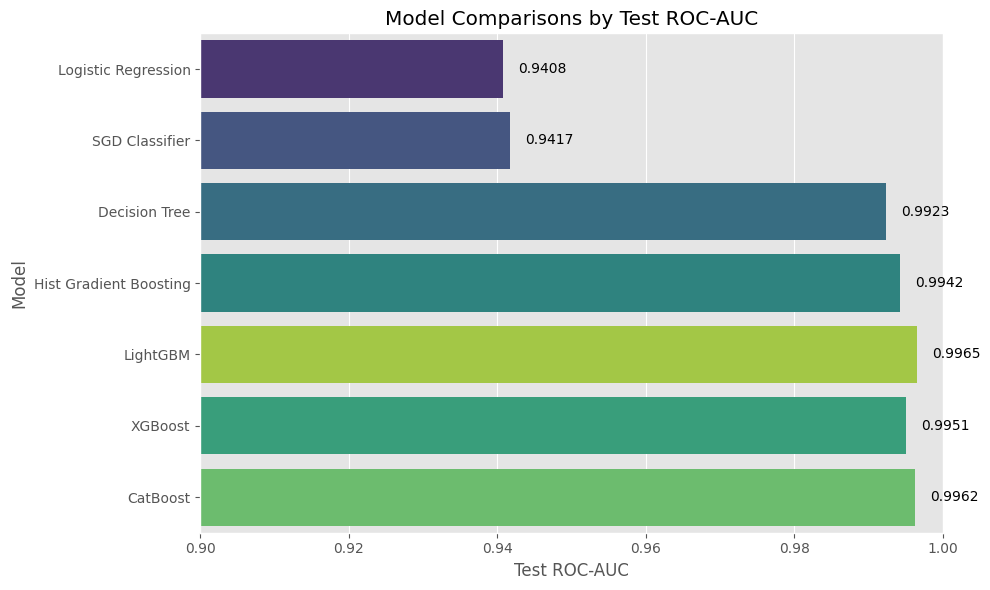

In [82]:
#Bar Plot Comparison of All Scores
model_best_scores = pd.DataFrame({
    'Model': ['Logistic Regression', 'SGD Classifier', 'Decision Tree', 'Hist Gradient Boosting', 'LightGBM', 'XGBoost', 'CatBoost'],
    'Test_AUC': [logreg_best_test_auc, sgd_test_auc, dt_test_auc, hgb_test_auc, lgb_test_auc, xgb_test_auc, cat_test_auc]})

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Test_AUC',
    y='Model',
    data=model_best_scores,
    hue=model_best_scores['Test_AUC'],
    palette=sns.color_palette('viridis', n_colors=len(model_best_scores)),
    legend=False
)
plt.xlabel('Test ROC-AUC')
plt.title('Model Comparisons by Test ROC-AUC')
plt.xlim(0.9, 1.0)
for index, row in model_best_scores.iterrows():
    plt.text(row.Test_AUC + 0.002, index, f'{row.Test_AUC:.4f}', va='center')
plt.tight_layout()
plt.show()

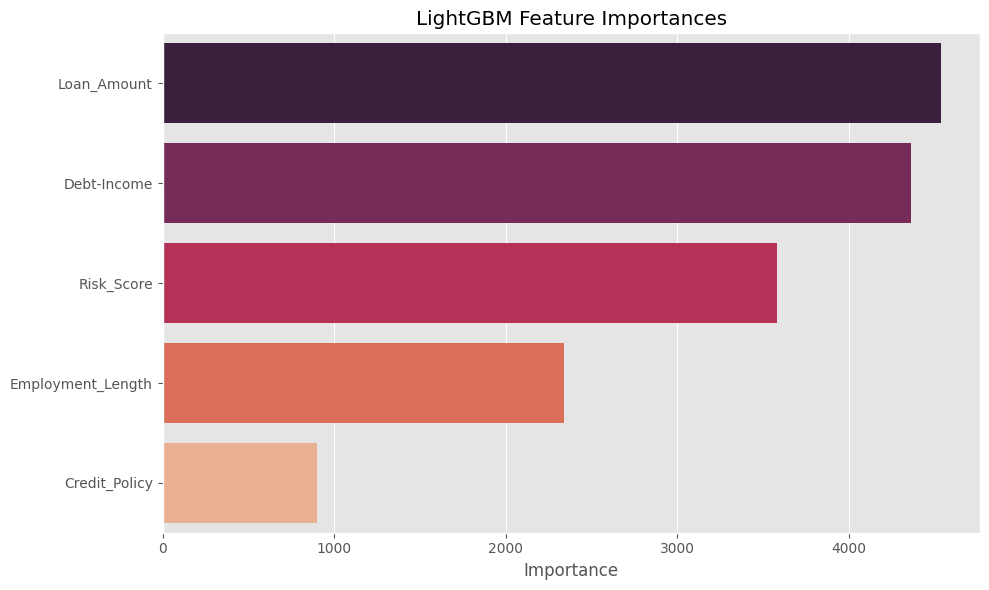

In [89]:
#Top Model (LightGBM) Feature Importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': lgb_best.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot horizontal barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importances,
    hue=feature_importances['Importance'],
    palette=sns.color_palette('rocket', n_colors=len(feature_importances))[::-1] ,
    legend=False
)

plt.title('LightGBM Feature Importances')
plt.xlabel('Importance')
plt.ylabel('')
plt.tight_layout()
plt.show()

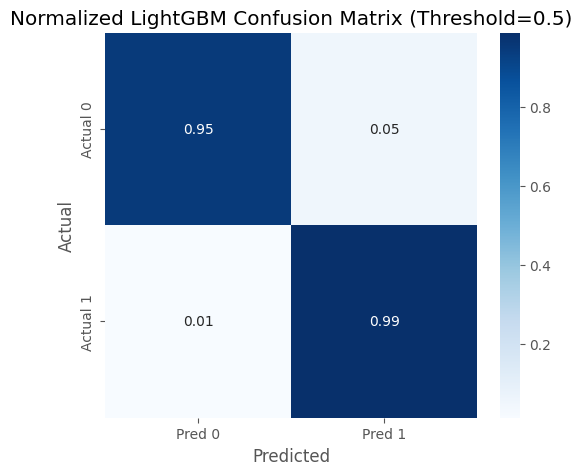

Accuracy      : 0.9791
Precision     : 0.9876
Recall        : 0.9865
Specificity   : 0.9481
F1 Score      : 0.9871
Cohen's Kappa : 0.9328


In [96]:
#---Normalized Confustion Matrix (Light GBM).  Default (.5) threshold

# Predict probabilities for the positive class
lgb_test_probs = lgb_best.predict_proba(X_test)[:, 1]

# Apply threshold (0.5)
threshold = 0.5
lgb_test_preds = (lgb_test_probs >= threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(Y_test, lgb_test_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues')
plt.title(f'Normalized LightGBM Confusion Matrix (Threshold={threshold})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Metrics
TN, FP, FN, TP = cm.ravel()

accuracy = accuracy_score(Y_test, lgb_test_preds)
precision = precision_score(Y_test, lgb_test_preds)
recall = recall_score(Y_test, lgb_test_preds)
specificity = TN / (TN + FP)
fscore = f1_score(Y_test, lgb_test_preds)
kappa = cohen_kappa_score(Y_test, lgb_test_preds)

# Print scores
print(f"Accuracy      : {accuracy:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"Specificity   : {specificity:.4f}")
print(f"F1 Score      : {fscore:.4f}")
print(f"Cohen's Kappa : {kappa:.4f}")

C:\Users\edjwe\pyenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


ROC-AUC: 0.7734570377211342
PR-AUC: 0.9468468005074974


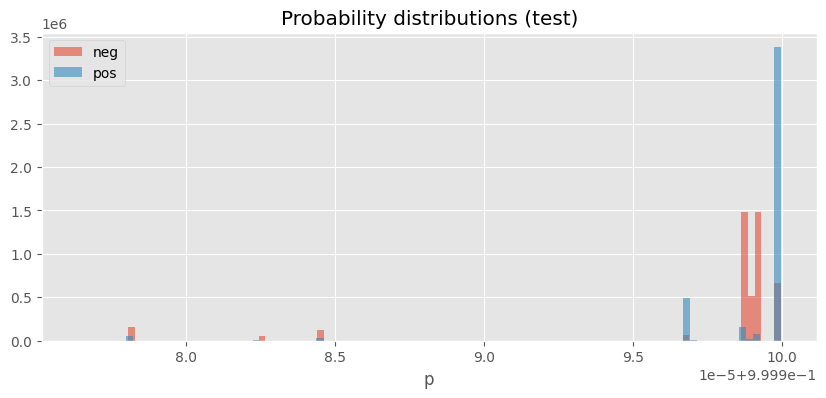

Brier score: 0.19205681708418326

Threshold 0.500000
Accuracy: 0.8079, Precision: 0.8079, Recall: 1.0000, Specificity: 0.0000, F1: 0.8938

Threshold 0.900000
Accuracy: 0.8079, Precision: 0.8079, Recall: 1.0000, Specificity: 0.0000, F1: 0.8938

Threshold 0.990000
Accuracy: 0.8079, Precision: 0.8079, Recall: 1.0000, Specificity: 0.0000, F1: 0.8938

Threshold 0.999000
Accuracy: 0.8079, Precision: 0.8079, Recall: 1.0000, Specificity: 0.0000, F1: 0.8938

Threshold 0.999900
Accuracy: 0.8079, Precision: 0.8079, Recall: 1.0000, Specificity: 0.0000, F1: 0.8938


C:\Users\edjwe\pyenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\edjwe\pyenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Youden thr: 0.9999998667248338 F1 thr: 0.9999780445448612


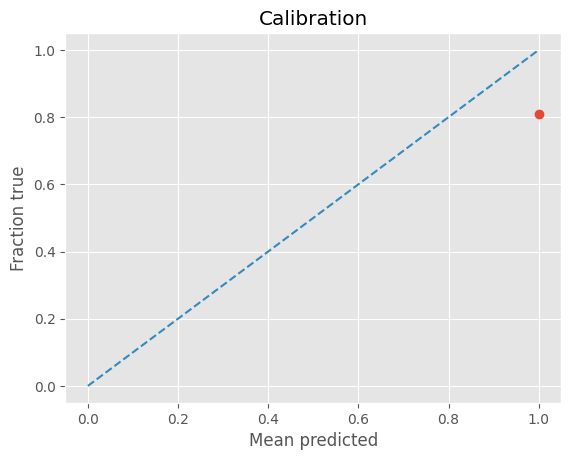

In [108]:
# 1) AUC & PR-AUC
probs_test = lgb_best.predict_proba(X_test_scaled)[:,1]
print("ROC-AUC:", roc_auc_score(Y_test, probs_test))
prec, rec, thr = precision_recall_curve(Y_test, probs_test)
print("PR-AUC:", auc(rec, prec))

# 2) Probability histograms by class
plt.figure(figsize=(10,4))
plt.hist(probs_test[Y_test==0], bins=100, alpha=0.6, label='neg', density=True)
plt.hist(probs_test[Y_test==1], bins=100, alpha=0.6, label='pos', density=True)
plt.legend(); plt.title("Probability distributions (test)"); plt.xlabel("p"); plt.show()

# 3) Calibration curve + Brier score
prob_true, prob_pred = calibration_curve(Y_test, probs_test, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o'); plt.plot([0,1],[0,1],'--'); plt.title("Calibration"); plt.xlabel("Mean predicted"); plt.ylabel("Fraction true")
print("Brier score:", brier_score_loss(Y_test, probs_test))

# 4) Threshold candidates and metrics summary
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
candidates = [0.5, 0.9, 0.99, 0.999, 0.9999]  # include Youden/F1 found earlier
for t in candidates:
    preds = (probs_test >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(Y_test, preds).ravel()
    print(f"\nThreshold {t:.6f}")
    print(f"Accuracy: {accuracy_score(Y_test,preds):.4f}, Precision: {precision_score(Y_test,preds):.4f}, Recall: {recall_score(Y_test,preds):.4f}, Specificity: {tn/(tn+fp):.4f}, F1: {f1_score(Y_test,preds):.4f}")

# 5) Find threshold by different criteria (Youden and F1)
from sklearn.metrics import roc_curve
fpr, tpr, roc_thr = roc_curve(Y_val, lgb_best.predict_proba(X_val_scaled)[:,1])
youden_idx = np.argmax(tpr - fpr); youden_thr = roc_thr[youden_idx]
# F1-opt threshold
prec_val, rec_val, thr_pr = precision_recall_curve(Y_val, lgb_best.predict_proba(X_val_scaled)[:,1])
f1s = 2*prec_val*rec_val/(prec_val+rec_val+1e-8)
f1_idx = np.argmax(f1s); f1_thr = thr_pr[f1_idx]
print("Youden thr:", youden_thr, "F1 thr:", f1_thr)